Let's build a short term memory first to analyze the problem and will improve it later

In [143]:
from dotenv import load_dotenv
load_dotenv()

True

In [144]:
from langgraph.store.memory import InMemoryStore

In [145]:
in_memory_store = InMemoryStore()

When storing the object(memories) in the Store, we provide:
- The namespace for the object, a tuple(similar to directories)
- The object key(think this a file)
- The object Value(think this as a content)

We use `put` method to save an object to the store by `namespace` and `key`

In [168]:
import uuid

user_id = "1"
namespace_for_memory = (user_id, "memories")

key = str(uuid.uuid4())

value = {"food_preferences" : "I like pizza"}

in_memory_store.put(namespace_for_memory, key, value)

In [169]:
# Search
memories = in_memory_store.search(namespace_for_memory)

print(memories[0].namespace)
print(memories[0].value)
print(memories[0].key)

('1', 'memories')
{'food_preferences': 'I like pizza'}
bec6f8d5-9b6e-4496-aaa2-17190a836e59


In [170]:
# Now we can use namespace and key to get memory using get
memory = in_memory_store.get(namespace_for_memory, key)
print(memory.dict())
print("-----")
print(memory.value.get("food_preferences"))

{'namespace': ['1', 'memories'], 'key': 'c0e333bb-3e80-48e7-89e1-6b8d08f9ce00', 'value': {'food_preferences': 'I like pizza'}, 'created_at': '2025-07-30T17:28:14.920043+00:00', 'updated_at': '2025-07-30T17:28:14.920044+00:00'}
-----
I like pizza


llm

In [171]:
# from langchain_google_genai import ChatGoogleGenerativeAI
# model = ChatGoogleGenerativeAI(
#     # model="gemini-2.0-flash",
#     model = "gemini-2.5-flash-lite",
#     temperature=0,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
# )

from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)


For short-term pointer, we will use `checkpointer`

In [172]:
from langgraph.checkpoint.memory import MemorySaver

For short-term pointer, we will use `Langchain store`

In [173]:
from langgraph.store.base import BaseStore

In [174]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

In [175]:
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the 
user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

In [ ]:
CREATE_MEMORY_INSTRUCTION = """You are collecting information about the user to personalize your responses.

USER INFORMATION FROM PREVIOUS INTERACTIONS:
{memory}

INSTRUCTIONS:
1. Carefully review the chat history below.
2. Identify new factual information about the user that is not already included above, such as:
   - Personal details (e.g., name, location)
   - Food preferences (e.g., likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Combine any new information with the existing memory to create a single, updated memory.
4. Format the updated memory as a clear, concise, bulleted list.
5. If any new information contradicts the existing memory, prefer the most recent version stated by the user.

Important: Only include information explicitly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:
"""


In [177]:
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """Load the memory from the store and use to personlaize the response"""

    user_id = config["configurable"]["user_id"]

    namespace = (user_id, "memory")

    key = "user_memory"

    existing_memory = store.get(namespace, key)

    if existing_memory:
        # Value is a dictionary with a memory key
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."

    # print(existing_memory_content)

    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=existing_memory_content)
    
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

In [ ]:
def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = (user_id, "memory")
    existing_memory = store.get(namespace, "user_memory")
        
    # Extract the memory
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory') # because i am putting value as dict with key memory
    else:
        existing_memory_content = "No existing memory found."

    print(f"-------{existing_memory_content}--------")

    # Format the memory in the system prompt
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=existing_memory_content)
    new_memory = model.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing memory in the store 
    key = "user_memory"
    
    if new_memory.content:
        print(f"New memory content: {new_memory.content}")
        store.put(namespace, key, {"memory": new_memory.content})
    else:
        print(f"\nNothing updating this time\n")
    # Write value as a dictionary with a memory key
    # store.put(namespace, key, {"memory": new_memory.content})
    

Building Graph

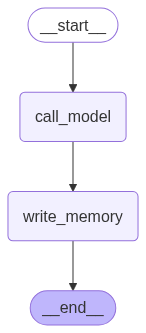

In [179]:
builder = StateGraph(MessagesState)

builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)

builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

across_memory_thread = InMemoryStore()

within_memory_thread = MemorySaver()

graph = builder.compile(checkpointer=within_memory_thread, store=across_memory_thread)


from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [180]:
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

input_messages = [HumanMessage(content="Hi, my name is Lance")]

In [181]:
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hi Lance! It's nice to meet you. How can I assist you today?
-------No existing memory found.--------
New memory content: - Name: Lance


In [182]:
user_id = "1"
# namespace = ("memory", user_id)
namespace = (user_id, "memory")

existing_memory = across_memory_thread.get(namespace, "user_memory")
existing_memory

Item(namespace=['1', 'memory'], key='user_memory', value={'memory': '- Name: Lance'}, created_at='2025-07-30T17:28:34.951233+00:00', updated_at='2025-07-30T17:28:34.951236+00:00')

In [183]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a great way to explore the city! San Francisco has some beautiful views and interesting neighborhoods to bike through. Do you have any favorite routes or spots you like to visit while biking?
-------- Name: Lance--------
New memory content: - Name: Lance
- Location: San Francisco
- Interests: Biking around San Francisco


In [184]:
user_id = "1"
# namespace = ("memory", user_id)
namespace = (user_id, "memory")

existing_memory = across_memory_thread.get(namespace, "user_memory")
existing_memory

Item(namespace=['1', 'memory'], key='user_memory', value={'memory': '- Name: Lance\n- Location: San Francisco\n- Interests: Biking around San Francisco'}, created_at='2025-07-30T17:28:44.128720+00:00', updated_at='2025-07-30T17:28:44.128723+00:00')

In [185]:
# User input 
input_messages = [HumanMessage(content="I also like to eat pizzas")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also like to eat pizzas
================================== Ai Message ==================================

Pizza and biking make a great combo! After a good ride, there's nothing like enjoying a delicious slice. Do you have a favorite pizza place in San Francisco?
-------- Name: Lance
- Location: San Francisco
- Interests: Biking around San Francisco--------
New memory content: Here's the updated information about you:

- Name: Lance
- Location: San Francisco
- Interests: Biking around San Francisco, eating pizzas

If there's anything else you'd like to share or update, feel free to let me know!


Let's check what is saved in the checkpointer

In [186]:
thread = {"configurable":{"thread_id": "1"}}

state =  graph.get_state(thread).values
for m in state["messages"]:
    print(m.content)
    print("--------")

Hi, my name is Lance
--------
Hi Lance! It's nice to meet you. How can I assist you today?
--------
I like to bike around San Francisco
--------
That sounds like a great way to explore the city! San Francisco has some beautiful views and interesting neighborhoods to bike through. Do you have any favorite routes or spots you like to visit while biking?
--------
I also like to eat pizzas
--------
Pizza and biking make a great combo! After a good ride, there's nothing like enjoying a delicious slice. Do you have a favorite pizza place in San Francisco?
--------


Let's check across_thread_memory

In [190]:
user_id = "1"
# namespace = ("memory", user_id)
namespace = (user_id, "memory")

existing_memory = across_memory_thread.get(namespace, "user_memory")
existing_memory.value

{'memory': "Here's the updated information about you:\n\n- Name: Lance\n- Location: San Francisco\n- Interests: Biking around San Francisco, eating pizzas\n\nIf there's anything else you'd like to share or update, feel free to let me know!"}

In [191]:
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi! Where would you recommend that I go biking?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi! Where would you recommend that I go biking?
================================== Ai Message ==================================

Hi, Lance! Since you're in San Francisco, there are some fantastic biking spots you might enjoy. Here are a few recommendations:

1. **Golden Gate Park**: This park has miles of bike paths and beautiful scenery, including gardens, lakes, and the famous windmills.

2. **The Embarcadero**: You can ride along the waterfront, enjoying views of the Bay Bridge and the Ferry Building. It’s a flat and scenic route.

3. **Crissy Field**: This area offers stunning views of the Golden Gate Bridge and the bay. The path is mostly flat and great for a leisurely ride.

4. **Twin Peaks**: If you're up for a challenge, biking to Twin Peaks will reward you with panoramic views of the city.

5. **Marin Headlands**: For a more adventurous ride, consider crossing the Golden Gate Bridge and explorin